In [225]:
from bot import get_historical_data
import pandas as pd
from binance.client import Client
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, make_scorer, precision_score
from itertools import combinations

In [226]:
transaction_costs = 0.0005
# Start investment is EURO!

In [227]:
# Fetch Bitcoin prices at 5-minute intervals for the last 40 days
symbol = 'BTCEUR'
days = 10000

bitcoin_data_hour = get_historical_data(symbol, Client.KLINE_INTERVAL_1HOUR, days)
#bitcoin_data_5minute = get_historical_data(symbol, Client.KLINE_INTERVAL_5MINUTE, days)

In [238]:
bitcoin_data_hour["Open time"]

0       2020-01-03 09:00:00+01:00
1       2020-01-03 10:00:00+01:00
2       2020-01-03 11:00:00+01:00
3       2020-01-03 12:00:00+01:00
4       2020-01-03 13:00:00+01:00
                   ...           
40337   2024-08-11 11:00:00+02:00
40338   2024-08-11 12:00:00+02:00
40339   2024-08-11 13:00:00+02:00
40340   2024-08-11 14:00:00+02:00
40341   2024-08-11 15:00:00+02:00
Name: Open time, Length: 40342, dtype: datetime64[ns, Europe/Berlin]

In [235]:
bitcoin_data_hour.shape

(40342, 52)

In [228]:
bitcoin_data_hour["pct"] = bitcoin_data_hour["Close"].pct_change().shift(-1)    #time shift ist WICHTIG! einer der häufigsten Fehler, wenn er vergessen wird
#bitcoin_data_5minute["pct"] = bitcoin_data_5minute["Close"].pct_change().shift(-1)

In [229]:
bitcoin_data_hour.dropna(inplace=True)
#bitcoin_data_5minute.dropna(inplace=True)

df_hour = bitcoin_data_hour
#df_5minute = bitcoin_data_5minute

In [230]:
def sharpe_ratio(s):
    s = np.log(1+s)
    sharpe = s.mean() / s.std()
    print(f"mean={s.mean():.6f}, std={s.std():.6f}")
    return sharpe

In [231]:
#Funktion um zu zählen wie häufig ein buy Signal hinter einander auftritt
def count_consecutive_ones(data: pd.DataFrame, signal_col: str):
    new_column_name = signal_col + "_count"
    
    count = 0
    counts = []
    
    for value in data[signal_col]:
        if value == 1:
            count += 1
        else:
            count = 0
        counts.append(count)
    
    data[new_column_name] = counts

### Indikatoren und Indexe berechnen

In [232]:
def OBV_berechnen(data:pd.DataFrame):
    #benötigt ein DataFrame mit den Spalten "4a. close (EUR)" und "5. volume"
    data["OBV"] = (np.sign(data["Close"].pct_change()) * data["Volume"]).cumsum()
    
def SMA_berechnen(data:pd.DataFrame, intervall:int):
    spalten_name = "SMA_"+str(intervall)
    data[spalten_name] = data["Close"].rolling(intervall).mean()
    spalten_name_sig = "SMA_"+str(intervall)+"_Sig"
    data[spalten_name_sig] = (data["Close"]>data[spalten_name]).astype(int)
    print(data[spalten_name_sig].mean())
    count_consecutive_ones(data, spalten_name_sig)
    
def RSI_berechnen(data:pd.DataFrame, intervall:int):

    spalten_name = "RSI_"+str(intervall)

    # Bestimme die Preisänderung zum jeweiligen Zeitpunkt t-1
    delta = data["Close"].diff()

    # Get rid of the first row, which has NaN values
    delta = delta[1:]

    # Calculate the gains and losses
    up = delta.where(delta > 0, 0)
    down = -delta.where(delta < 0, 0)

    # Calculate the rolling average of the gains and losses
    #window_size = 14 #als default
    avg_gain = up.rolling(intervall).mean()
    avg_loss = down.rolling(intervall).mean()

    # Calculate the relative strength
    rs = avg_gain / avg_loss

    # Calculate the RSI
    data[spalten_name] = 100 - (100 / (1 + rs))
    
def EMA_berechnen(data: pd.DataFrame, intervall: int):
    spalten_name = "EMA_" + str(intervall)
    data[spalten_name] = data["Close"].ewm(span=intervall, adjust=False).mean()
    spalten_name_sig = "EMA_"+str(intervall)+"_Sig"
    data[spalten_name_sig] = (data["Close"]>data[spalten_name]).astype(int)
    count_consecutive_ones(data, spalten_name_sig)

def HMA_berechnen(data: pd.DataFrame, intervall: int):
    spalten_name = "HMA_" + str(intervall)
    half_length = int(intervall / 2)
    sqrt_length = int(np.sqrt(intervall))

    wma_half = data["Close"].rolling(window=half_length).mean()
    wma_full = data["Close"].rolling(window=intervall).mean()

    raw_hma = 2 * wma_half - wma_full
    data[spalten_name] = raw_hma.rolling(window=sqrt_length).mean()
    
    spalten_name_sig = "HMA_"+str(intervall)+"_Sig"
    data[spalten_name_sig] = (data["Close"]>data[spalten_name]).astype(int)
    count_consecutive_ones(data, spalten_name_sig)

def MACD_berechnen(data: pd.DataFrame, fast_period: int = 12, slow_period: int = 26, signal_period: int = 9):
    data["MACD"] = data["Close"].ewm(span=fast_period, adjust=False).mean() - data["Close"].ewm(span=slow_period, adjust=False).mean()
    data["MACD_Signal"] = data["MACD"].ewm(span=signal_period, adjust=False).mean()

def Momentum_berechnen(data: pd.DataFrame, intervall: int):
    spalten_name = "Momentum_" + str(intervall)
    data[spalten_name] = data["Close"].diff(intervall)

def Stochastic_RSI_berechnen(data: pd.DataFrame, intervall: int):
    spalten_name = "StochRSI_" + str(intervall)

    delta = data["Close"].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=intervall).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=intervall).mean()

    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))

    min_RSI = RSI.rolling(window=intervall).min()
    max_RSI = RSI.rolling(window=intervall).max()

    data[spalten_name] = (RSI - min_RSI) / (max_RSI - min_RSI)

In [233]:
indicators = []
dt_indicators = []
OBV_berechnen(df_hour)
MACD_berechnen(df_hour)
dt_indicators.extend([f'OBV', f'MACD'])
for i in [24, 24*7, 24*100]:#[5, 10, 20, 50, 100, 500, 1000]:
    SMA_berechnen(df_hour, i)
    RSI_berechnen(df_hour, i)
    EMA_berechnen(df_hour, i)
    HMA_berechnen(df_hour, i)
    Momentum_berechnen(df_hour, i)
    Stochastic_RSI_berechnen(df_hour, i)
    indicators.extend([f"RSI_{i}", f"EMA_{i}", f"HMA_{i}", f"Momentum_{i}", f"StochRSI_{i}"])
    dt_indicators.extend([f"RSI_{i}", f"SMA_{i}_Sig", f"EMA_{i}_Sig", f"HMA_{i}_Sig", f"Momentum_{i}", f"StochRSI_{i}"])
    

0.5248624262555154
0.5368846363591294
0.5852461454563482


<BarContainer object of 24 artists>

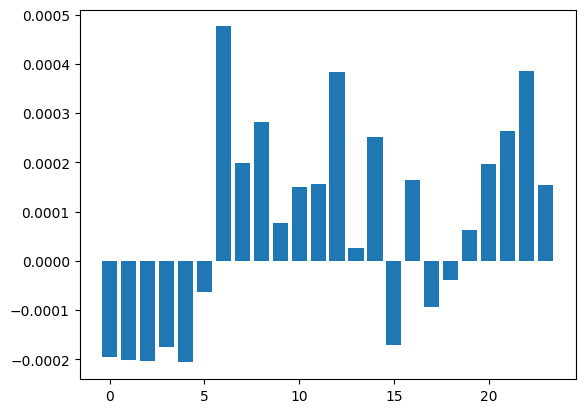

In [240]:
df_hour["Hour"] = df_hour["Open time"].dt.hour
tmp = df_hour.groupby("Hour")["pct"].mean()
plt.bar(x=tmp.index, height=tmp)

In [241]:
# Calendar Effects:
df_hour["Is_AfterHour"] = df_hour["Open time"].dt.hour >= 22
df_hour["Is_Monday"] = df_hour["Open time"].dt.day_of_week == 0
dt_indicators.extend([f'Is_AfterHour', f'Is_Monday'])

In [242]:
#berechnet performance für das gewollte Zeitfenster
def create_labels(data: pd.DataFrame, window: int):
    data["future_return"] = data["Close"].shift(-window) / data["Close"] - 1
    data["label"] = (data["future_return"] > transaction_costs*2).astype(int)
    data.dropna(inplace=True)

In [243]:
from sklearn import tree
def train_model(data: pd.DataFrame, features: list, target: str, param_grid, estimator):
    # Indizes zurücksetzen, um Probleme mit der Indizierung zu vermeiden
    data = data.reset_index(drop=True)
    
    # Aufteilen der Daten in Trainings- und Testdaten
    train_size = int(len(data) * 0.8)
    train_data = data.iloc[:train_size]
    test_data = data.iloc[train_size:]
    X_train = train_data[features]
    X_test = test_data[features]
    y_train = train_data[target]
    
    # Definiere den Precision-Scorer
    precision_scorer = make_scorer(precision_score, pos_label=1)
    
    # Initialisiere den GridSearchCV
    grid_search = GridSearchCV(estimator=estimator,
                               param_grid=param_grid,
                                cv=4,  # Anzahl der Cross-Validation-Folds
                                scoring=precision_scorer,  # Bewertungskriterium
                                n_jobs=-1,  # Nutze alle verfügbaren CPU-Kerne
                                verbose=2)  # Ausgabe von Fortschrittsinformationen

     # Führe GridSearch aus
    grid_search.fit(X_train, y_train)
    
    # Ausgabe der besten Parameter
    print("Beste Parameter:", grid_search.best_params_)
    
    # Modell mit den besten Parametern
    best_clf = grid_search.best_estimator_
    return best_clf, X_test
    
def make_signals(pred: pd.Series, holding_period: int):
    np_pred = pred
    for i in reversed(range(len(np_pred))):
        if np_pred[i] == 1:
            np_pred[i:i+holding_period] = 1
    np_pred = np_pred
    return np_pred 
    
def evaluate_model(X_test, best_clf, data, signal_threshold, holding_period, plot=True):
    # Vorhersagen auf Testdaten
    #y_pred = best_clf.predict(X_test)
    
    #best_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
    #best_clf.fit(X_train, y_train)
    
    # TODO print out sharpe ratio in training data set
    # y_pred_proba = best_clf.predict_proba(X_train)
    # y_pred = (y_pred_proba[:, 1] > signal_threshold).astype(int)
    # y_pred = make_signals(y_pred, holding_period)
    # print(f"Sharpe Strategy (Train): {sharpe}")

    # Get the predicted probabilities
    y_pred_proba = best_clf.predict_proba(X_test)
    y_pred = (y_pred_proba[:, 1] > signal_threshold).astype(int)
    y_pred = make_signals(y_pred, holding_period)
    
    # Berechne die Sharpe Ratio
    test_returns = data.loc[X_test.index, "pct"]
    print(f'Sharpe BTC {sharpe_ratio(test_returns)}')

    strat_returns = test_returns.copy()
    strat_returns[y_pred == 0] = 0
    sharpe = sharpe_ratio(strat_returns)
    print(f"Sharpe Strategy (Test): {sharpe}")
    


    
    # Performance DataFrame erstellen
    if plot:
        PF = pd.DataFrame(data["pct"].iloc[X_test.index])
        PF["pred"] = y_pred
        PF["strategy_returns"] = PF["pred"] * PF["pct"]
        PF["cumulative_strategy_returns"] = (PF["strategy_returns"] + 1).cumprod()

        PF["benchmark_returns"] = PF["pct"]
        PF["cumulative_benchmark_returns"] = (PF["benchmark_returns"] + 1).cumprod()
        
        # Plotten der Ergebnisse
        plt.figure(figsize=(14, 7))
        plt.plot(PF["cumulative_strategy_returns"], label="Strategy Returns")
        plt.plot(PF["cumulative_benchmark_returns"], label="Benchmark Returns")
        plt.title("Cumulative Returns")
        plt.xlabel("Time")
        plt.ylabel("Cumulative Returns")
        plt.legend()
        plt.show()
    
    return sharpe

In [265]:
def find_best_indicators(data: pd.DataFrame, indicators: list, target: str, holding_period, signal_threshold):
    best_sharpe = -np.inf
    best_combination = None
    best_model = None

    # Definiere den Parameterbereich für GridSearch
    param_grid = {
        #'criterion': ['gini', 'entropy'],
        'max_depth': [5, 10, 20],
        #'min_samples_split': [2, 5, 10],
        #'min_samples_leaf': [5, 10, 20, 30],
        #'max_features': [None, 'sqrt', 'log2']
    }

    for r in range(1, len(indicators) + 1):
        for combo in combinations(indicators, r):
            if len(combo)<4:
                continue
            print(combo)
            features = list(combo)
            clf, X_test = train_model(data, features, target, param_grid=param_grid, estimator=DecisionTreeClassifier(random_state=42))
            sharpe = evaluate_model(X_test, clf, signal_threshold=signal_threshold, holding_period=holding_period, data=data)
            if sharpe > best_sharpe:
                best_sharpe = sharpe
                best_combination = combo
                best_model = clf

    print(f"Best Sharpe Ratio: {best_sharpe}")
    print(f"Best Indicator Combination: {best_combination}")

    return best_model, best_combination, best_sharpe

In [266]:
HOLDING_WINDOW = 1

In [267]:
# Labels erstellen
create_labels(df_hour, window=HOLDING_WINDOW)

In [268]:
#dt_indicators.extend([f'EMA_{5}', f'EMA_{50}', f'EMA_{500}'])
# Liste der Indikatoren
features = dt_indicators#["SMA_50_Sig", "SMA_500_Sig", "HMA_50_Sig", "EMA_50_Sig", "EMA_500_Sig", "EMA_5_Sig"]#["OBV", "RSI_5", "RSI_10"]#, "RSI_50", "RSI_50", "MACD", "MACD_Signal", "Momentum_10", "StochRSI_10", "StochRSI_20", "StochRSI_50"]

('OBV', 'MACD', 'RSI_24', 'SMA_24_Sig')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 20}
mean=0.000047, std=0.004235
sharpe test 0.01109584683047931
mean=-0.000015, std=0.001894
Sharpe Ratio: -0.007918331975942721


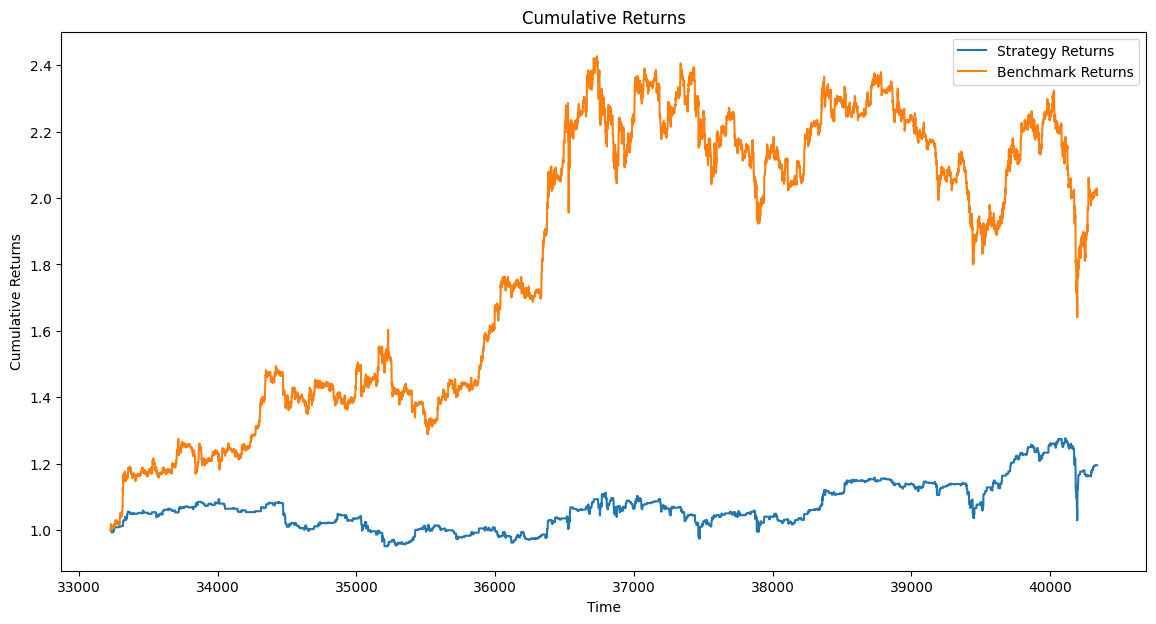

('OBV', 'MACD', 'RSI_24', 'EMA_24_Sig')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 20}
mean=0.000047, std=0.004235
sharpe test 0.01109584683047931
mean=0.000050, std=0.002090
Sharpe Ratio: 0.02404338644270044


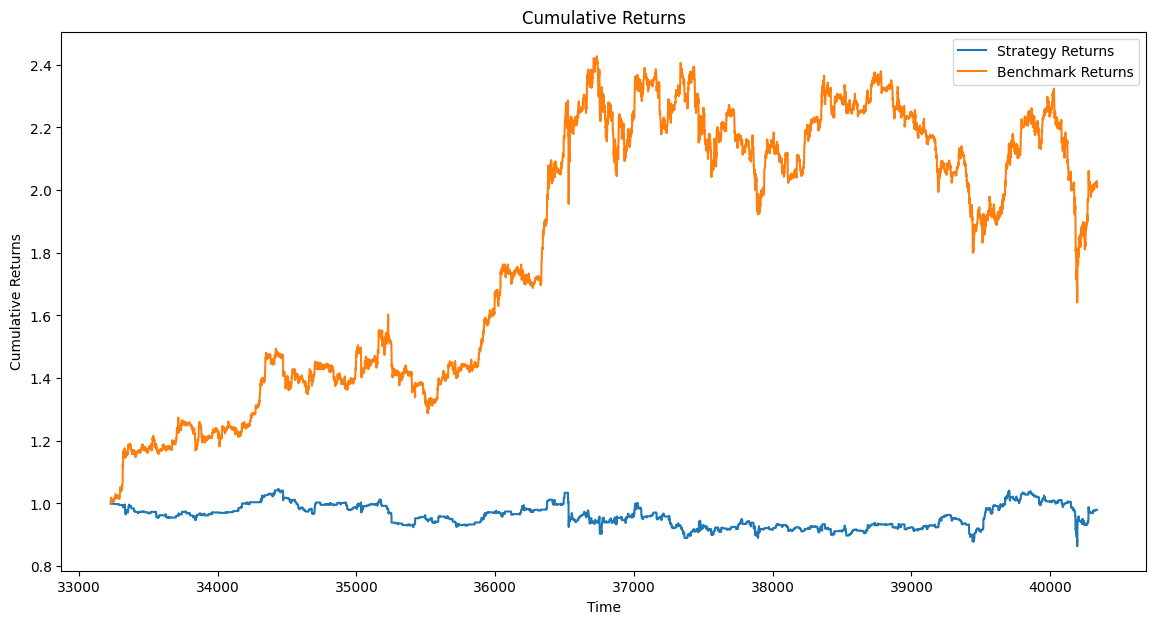

('OBV', 'MACD', 'RSI_24', 'HMA_24_Sig')
Fitting 4 folds for each of 3 candidates, totalling 12 fits
Beste Parameter: {'max_depth': 20}
mean=0.000047, std=0.004235
sharpe test 0.01109584683047931
mean=0.000020, std=0.001906
Sharpe Ratio: 0.010734732930355137


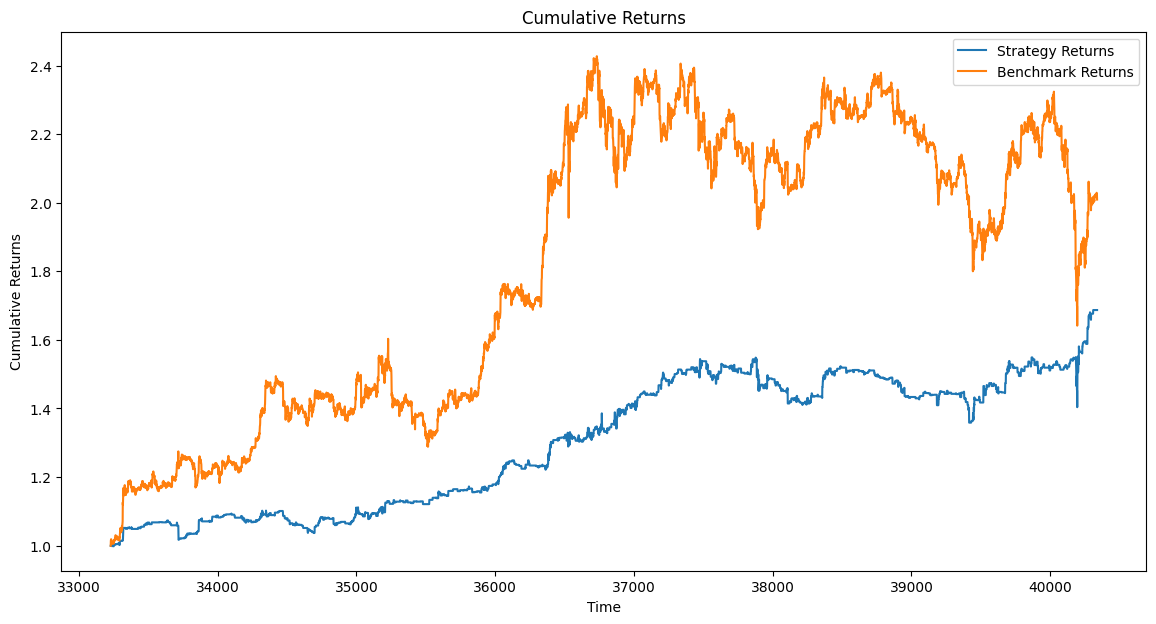

('OBV', 'MACD', 'RSI_24', 'Momentum_24')
Fitting 4 folds for each of 3 candidates, totalling 12 fits


KeyboardInterrupt: 

In [269]:
# Beste Indikatoren finden
best_model, best_combination, best_sharpe = find_best_indicators(df_hour, features, holding_period=HOLDING_WINDOW, target="label", signal_threshold=0.55)

man könnte probieren, zu zählen wie häufig die Buy-Signale bei den Averages hintereinander aufkommen und das dann in den DT übergeben. 

# Single Model Analysis

In [248]:
create_labels(df_hour, window=HOLDING_WINDOW)

In [255]:
# Definiere den Parameterbereich für GridSearch
param_grid = {
    #'criterion': ['gini', 'entropy'],
     'max_depth': [5],
    # 'min_samples_split': [2, 5, 10],
    # 'min_samples_leaf': [1000, 10000],
    #'max_features': [None, 'sqrt', 'log2']
}
clf, X_test = train_model(data=df_hour, features=features, target="label", param_grid=param_grid, estimator=DecisionTreeClassifier(random_state=42))

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {'max_depth': 5}


In [256]:
th = 0.5
sharpe = evaluate_model(X_test, clf, data=df_hour, signal_threshold=th, holding_period=HOLDING_WINDOW, plot=False)

mean=0.000047, std=0.004235
sharpe test 0.011135191183199096
mean=-0.000016, std=0.000982
Sharpe Ratio: -0.016189453798126696


In [257]:
from functools import partial

plot_func = partial(evaluate_model, X_test=X_test, best_clf=clf, data=df_hour, holding_period=HOLDING_WINDOW, plot=False)
xs = np.arange(0.5, 1, 0.05)
ys = np.ndarray(shape=len(xs))
for i in range(len(xs)):
     ys[i] = plot_func(signal_threshold=xs[i])

mean=0.000047, std=0.004235
sharpe test 0.011135191183199096
mean=-0.000016, std=0.000982
Sharpe Ratio: -0.016189453798126696
mean=0.000047, std=0.004235
sharpe test 0.011135191183199096
mean=0.000001, std=0.000373
Sharpe Ratio: 0.003414835910630701
mean=0.000047, std=0.004235
sharpe test 0.011135191183199096
mean=0.000004, std=0.000238
Sharpe Ratio: 0.017593374341898546
mean=0.000047, std=0.004235
sharpe test 0.011135191183199096
mean=0.000004, std=0.000238
Sharpe Ratio: 0.017593374341898546
mean=0.000047, std=0.004235
sharpe test 0.011135191183199096
mean=0.000000, std=0.000000
Sharpe Ratio: nan
mean=0.000047, std=0.004235
sharpe test 0.011135191183199096
mean=0.000000, std=0.000000
Sharpe Ratio: nan
mean=0.000047, std=0.004235
sharpe test 0.011135191183199096
mean=0.000000, std=0.000000
Sharpe Ratio: nan
mean=0.000047, std=0.004235
sharpe test 0.011135191183199096
mean=0.000000, std=0.000000
Sharpe Ratio: nan
mean=0.000047, std=0.004235
sharpe test 0.011135191183199096
mean=0.000000

C:\Users\Adria\AppData\Local\Temp\ipykernel_251180\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_251180\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_251180\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_251180\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_251180\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_251180\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Text(0, 0.5, 'sharpe')

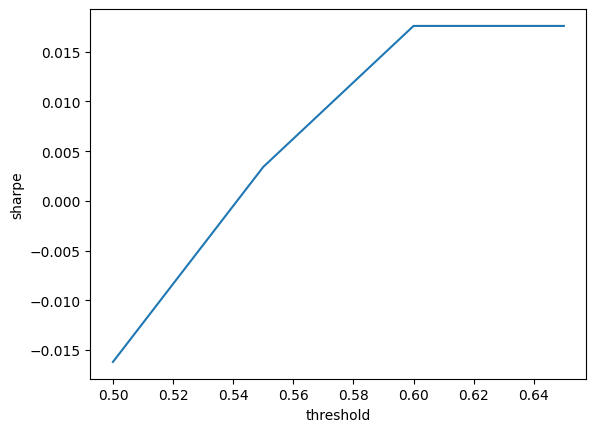

In [258]:
plt.plot(xs, ys)
plt.xlabel("threshold")
plt.ylabel("sharpe")

mean=0.000047, std=0.004235
sharpe test 0.011135191183199096
mean=0.000004, std=0.000238
Sharpe Ratio: 0.017593374341898546


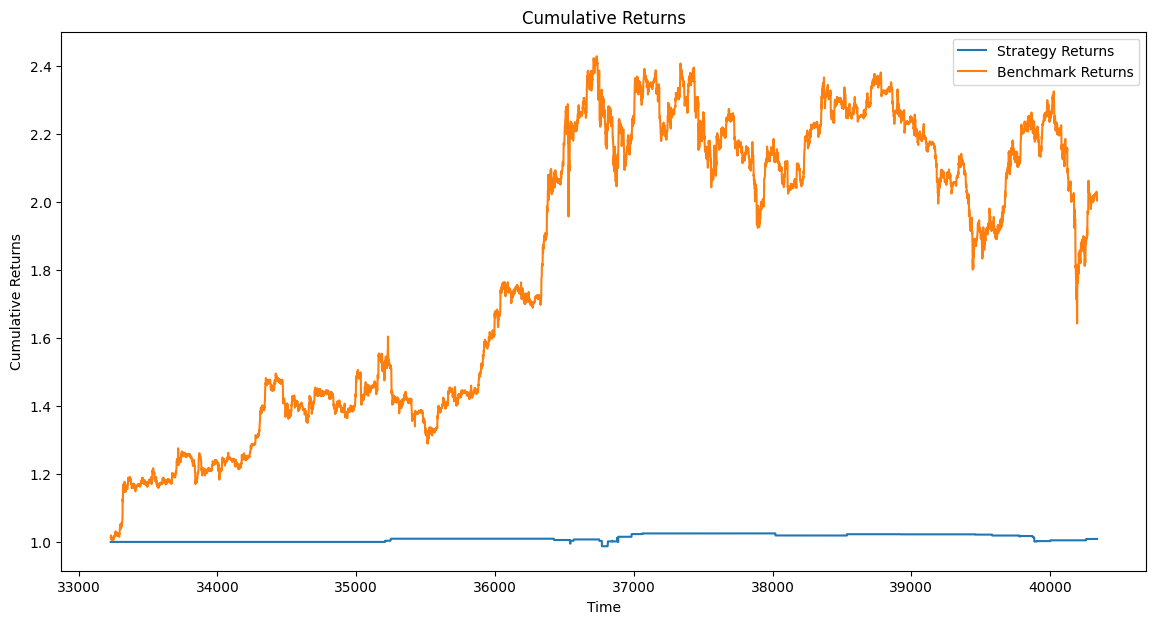

np.float64(0.017593374341898546)

In [261]:
evaluate_model(signal_threshold=0.6,
              X_test=X_test, 
              best_clf=clf, 
              data=df_hour, 
              holding_period=HOLDING_WINDOW,
              plot=True)

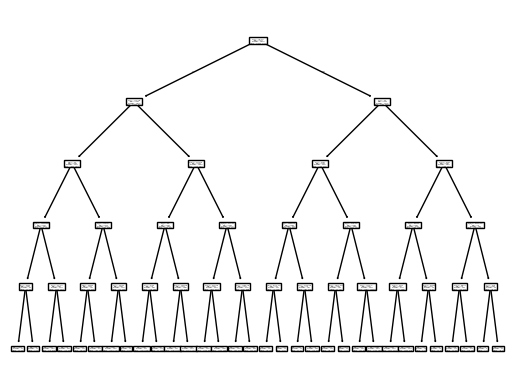

In [262]:
_ = tree.plot_tree(clf)